Dou et al. (2020) model

Agora em Julia versão 1.5.3

respond_payment v5

In [60]:
using LinearAlgebra, Statistics

# using Distributions, Expectations, NLsolve, Roots, Random, Plots, Parameters

using VegaLite




#packages to increase the speed of the code
using BenchmarkTools
using Profile # @profile command
using ProfileVega #profiling using graphs
# using StatProfilerHTML
using ProfileView #profiling using graphs
# using Traceur #analyses if your function has performance flaws such as changing the type of a variable


Game parameters

In [2]:
const μ = Float64(4.566) #number of months in each period
const ρ = Float64(0.884) # (1 - ρ) is the firm's depreciation rate each period
# const ρ = Float64(0.5) #testing new depreciation rate
const β = Float64(9.84) #inverse of the speed of learning
const c0 = Float64(0.044) #fixed cost of going to court
const c1 = Float64(0.015) #variable cost of going to court


const hs0 = Float64(0.28) #senior's initial skill level
const hj0 = Float64(0.36) #junior's initial skill level

const λj = Float64(0.346)

#const is to alert Julia that these global variables will not change, so she does not have to worry about then

0.346

Data

In [3]:
const Vmax = Float64(1.0) #firm's maximum reorganization value
const L = Float64(0.25) #firm's maximum liquidation value
const Ds = Float64(0.32) #senior's debt face value
const Dj = Float64(0.68) #junior's debt face value

const D = Ds + Dj #total debt, used to scale costs

1.0

Initial definitions: costs, maximum value of the firm, maximum number of periods



### Important: we will create a game with T+1 periods

So we'll be able to include period t==0 in the arrays

So the notation is: period t is represented by the index t-1


In [4]:
#cost function
function Ct(t)
    #cost at period t=0(index1) is 0
    if(t <= 1)
        return 0
    else
        return c0 * D + c1 * (t-1) * D
    end
end

#precisa de um 'end' para o if e um 'end' para a função
    
#test
@show Ct(0)    
@show Ct(1)
@show Ct(2)
@show Ct(2) == c0 * D + c1 * (1) * D


Ct(0) = 0
Ct(1) = 0
Ct(2) = 0.059
Ct(2) == c0 * D + c1 * 1 * D = true


true

In [5]:
#liquidation payoffs

function s_L(t)
    return min(L - Ct(t), Ds)
end

@show s_L(0)
@show s_L(1)
@show s_L(2)


function j_L(t)
    return min(L - Ct(t) - s_L(t), Dj)
end
    
@show j_L(1)

s_L(0) = 0.25
s_L(1) = 0.25
s_L(2) = 0.191
j_L(1) = 0.0


0.0

In [6]:
#number of periods
function max_turns(Vmax, L, ρ)
    t = 0
    
    while(ρ^(t-1) * Vmax > L)
        t = t+1
    end
    return t
end


T = max_turns(Vmax, L, ρ)
T

13

In [7]:
#checking if T is indeed the final period
@show t = T
@show ρ^(t-1) * Vmax - Ct(t) > L - Ct(t)


@show t = T-1
@show ρ^(t-1) * Vmax - Ct(t) > L - Ct(t)


#to see the values
@show t = T-1
@show ρ^(t-1) * Vmax - Ct(t)

@show L - Ct(t)

t = T = 13
ρ ^ (t - 1) * Vmax - Ct(t) > L - Ct(t) = false
t = T - 1 = 12
ρ ^ (t - 1) * Vmax - Ct(t) > L - Ct(t) = true
t = T - 1 = 12
ρ ^ (t - 1) * Vmax - Ct(t) = 0.04861723529489925
L - Ct(t) = 0.041000000000000036


0.041000000000000036

In [8]:
#maximum value of reorganization each period
function Vt(Vmax, Tmax, ρ)
    
    V = Array{Float64}(undef, Tmax+1)
    V[1] = Vmax
    
    #we include T+1 because we want to include to include period t==0
    
    for t in 2:Tmax+1
        
        V[t] = Vmax * ρ^((t-1)-1) #(t-1) because the index starts at 1 in Julia
    end
    
    return V
end

V = Vt(Vmax, T, ρ)
V

#index 1 corresponds to t=0 and 2 to t=1...

14-element Array{Float64,1}:
 1.0
 1.0
 0.884
 0.781456
 0.690807104
 0.6106734799360001
 0.539835356263424
 0.4772144549368668
 0.4218575781641903
 0.37292209909714424
 0.3296631356018755
 0.29142221187205797
 0.2576172352948992
 0.2277336360006909

In [9]:
#array with costs each period

C = similar(V)

C[1] = 0

for t in 2:T+1
    C[t] = Ct(t)
end
    
C

14-element Array{Float64,1}:
 0.0
 0.059
 0.074
 0.089
 0.104
 0.119
 0.134
 0.149
 0.16399999999999998
 0.179
 0.194
 0.20899999999999996
 0.22399999999999998
 0.239

Skill levels' grid and Probability Mass Function(PMF)

Important: we won't use the skill levels directly in the functions, we will use their indexes. For example, index = 40 corresponds to $\theta_{K,t} = 0.4$.

In [10]:
#grid size
const grid = 100

hlow = 0.01
hhigh = 1.0


hvals = LinRange(hlow, hhigh, grid)

hvals
hvals[6]

0.06

In [11]:
#array to tell us the size of the pie at period t
#arguments: (period, θk,t)
U = Array{Float64}(undef,T+1, grid)


#cartesianIndices returns the index(i,j), and index(i,j)[1] = i, index(i,j)[2] = j
for i in CartesianIndices(U)
    U[i] = hvals[i[2]] * V[i[1]] - C[i[1]]
end  

#if t==0 (index 1), then there are no costs
@show U[1,7] == hvals[7] * V[1]

@show U[1, 7] == hvals[7] * Vmax

#if t>0 (index>1), there are costs
@show U[2,1] == hvals[1] * V[2] - Ct(2)

#checking the last period, T, whose index is "T+1"
#t = T+1
@show U[T+1,7] ==  hvals[7] * V[T+1] - Ct(T+1)

U[1, 7] == hvals[7] * V[1] = true
U[1, 7] == hvals[7] * Vmax = true
U[2, 1] == hvals[1] * V[2] - Ct(2) = true
U[T + 1, 7] == hvals[7] * V[T + 1] - Ct(T + 1) = true


true

In [12]:
#cumulative distribution function
function cdf(x, lt)
    
    #return the cdf of x given the lower bound lt
    #geq than 1 because of our discretization method 
    if(x >= 1.0)
        
        return 1.0
    
    else
        
        if(x >= lt)
            return 1.0 - ((1.0-x)^β)/((1-lt)^β)
        else
            return 0.0
        end
    end
end

#test      
@show cdf(0.5, 1)

@show cdf(0.5, 0.4)

@show cdf(0.99, 0.01)

@show cdf(1, 0.01)

@show cdf(1, 0.9)

cdf(0.5, 1) = 0.0
cdf(0.5, 0.4) = 0.8337136736331454
cdf(0.99, 0.01) = 1.0
cdf(1, 0.01) = 1.0
cdf(1, 0.9) = 1.0


1.0

In [13]:
#pmf: each point of the grid is at the center of the cdf
function pmf_cdf(lt, δ = hlow/2)
    pmf = zeros(grid)
    
    for (i, h) in enumerate(hvals)
        pmf[i] = cdf(h+δ, lt) - cdf(h-δ, lt)
    end
    
    return pmf
end


lt = 0.01
pmf_cdf(lt)

100-element Array{Float64,1}:
 0.048602089527521986
 0.09088953125821697
 0.08301186884522238
 0.07574579901540057
 0.06904947823155516
 0.06288353216214904
 0.05721093367839869
 0.05199688568380789
 0.04720870863310611
 0.04281573260029048
 0.038789193758253626
 0.03510213513518168
 0.03172931151561542
 ⋮
 3.7337122282821156e-10
 1.615731992643532e-10
 6.408462649432067e-11
 2.2833512858255745e-11
 7.107758825952715e-12
 1.856736986383112e-12
 3.83026943495679e-13
 5.651035195342047e-14
 4.9960036108132044e-15
 2.220446049250313e-16
 0.0
 0.0

In [14]:
#generating the pmfs

#probability mass function
pmf = Array{Float64}(undef,grid,grid)


for (t, θt) in enumerate(hvals)
    pmf[t,:] = pmf_cdf(θt)
end


#we need a pmf for when we have lkt and want to know θk,t+1
#we will call it 'pmf2'
pmf2 = similar(pmf)

for i in eachindex(hvals)
    for j in eachindex(hvals)
        pmf2[i, j] = sum(pmf[i, :] .* pmf[:, j])
    end
end

#rows are the skill levels today, columns are the skill levels tomorrow
pmf2[1,:] - pmf[1,:]

#should be nice to plot the two pmfs, so we will get the intuition easily

100-element Array{Float64,1}:
 -0.046239926421080726
 -0.08201062544335427
 -0.06652389304197329
 -0.05297653770265348
 -0.04117778693388258
 -0.03095216055945394
 -0.022138473358402036
 -0.014588889342129194
 -0.008168025651978328
 -0.0027521041142639507
  0.0017718514572064026
  0.0055067740688657385
  0.008546270271650315
  ⋮
  7.710965259700306e-9
  3.4895426000488317e-9
  1.4511143376026725e-9
  5.43807346649936e-10
  1.7875565752175066e-10
  4.95698020399729e-11
  1.093125330283789e-11
  1.7426855209729608e-12
  1.6978822815991093e-13
  7.239768851825965e-15
  5.665150746454088e-17
  8.758153619997799e-22

Arrays with the continuation values

In [15]:
#continuation values
#period t (not t+1), θkt, ℓkt, ℓmt
s_W = zeros(T+1, grid, grid, grid)
j_W = similar(s_W)


#optimal payments
#period, θkt, ℓmt, outputs
Pst_array = zeros(T, grid, grid, 6) #we won't need payment proposal for period T, a.k.a. "T+1"
Pjt_array = similar(Pst_array)

13×100×100×6 Array{Float64,4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.

In [16]:
#populating the last period with the liquidation values
s_W[T+1, :, :, :] .= s_L(T+1) #we need to use .= because it is a broadcast
j_W[T+1, :, :, :] .= j_L(T+1)

100×100×100 view(::Array{Float64,4}, 14, :, :, :) with eltype Float64:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  

In [17]:
#cutoff function: upgrade

function getcutoff_m(t, pkt, hkt, m_W)

    #we extract the diagonal values, where θmt == lmt, to search for the cutoff
    diag_vals = @views diag(m_W[t+1, :, :, hkt])
    
    
    #we don't need to worry about negative payment offers because in this case the cutoff will be 1
    #if the pkt is greater than all the continuation values of the adversary, then it will return '101'
    return searchsortedfirst(diag_vals, pkt+0.001) #adding 0.001 to get cases when diag_vals > pkt, strictly
end

#should return 100 because J's continuation value at T is zero
@btime getcutoff_m(T, 0.01, 50, j_W)


  218.972 ns (1 allocation: 896 bytes)


101

In [18]:
#function to update the lowerbound according to the cutoff
#get the right lmt+1

function cutoff_m(t, pkt, hkt, lmt, m_W)
    cmt = getcutoff_m(t, pkt, hkt, m_W)
    
    
    #if there is no cutoff (cutoff==101), then cutoff_m will return 101
    if(cmt==101)
        return cmt
    else
        return max(cmt, lmt)
    end
end


@btime cutoff_m(T, 0.01, 50, 40, j_W)

  222.614 ns (1 allocation: 896 bytes)


101

In [19]:
#function to select the pmf function as it is writen in the paper

function h_m(t, lmt, pmf, pmf2)
    #takes the indexes of cutoff and lmt
        
    #at t=0(index 1), all information is symmetric, so we use pmf instead of pmf2
    if(t <= 1)
        return pmf[lmt, 1:end]
    else
        return pmf2[lmt, 1:end]
    end
end
    
#test
@btime h_m(2,50, pmf, pmf2)

  146.136 ns (1 allocation: 896 bytes)


100-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 4.625716199215591e-6
 2.128501871030038e-6
 8.99899204442307e-7
 3.428623147305904e-7
 1.1459581460290833e-7
 3.2321165203169804e-8
 7.253369111549412e-9
 1.1778647340830674e-9
 1.1710929608790348e-10
 5.110233142412765e-12
 4.3007226426965164e-14
 1.7849057398291997e-18

In [20]:
U[T, 100]

0.03361723529489924

In [21]:
s_L(T)

0.026000000000000023

In [22]:
#version passing global variables as parameters

share = [0.0:hlow:hhigh;]  #possible shares of the pie



#testing cutoff in this newer version of Pkt

#function to calculate the optimal payment offer and directly populate the array

function Pkt(t, hkt, lmt, k_W, m_W, k_L, Pkt_array, pmf, pmf2, share, U)
    
    
    Pkt_grid = Vector{Float64}(undef, length(share)+1)

#     Pkt_grid = zeros(length(share)+1)
    
    #the first input is -Vmax, to assure that m will reject all offers. It is the waiting payoff
    Pkt_grid[1] = -Vmax

    #t+1 is just because we have T+1 periods in U, so U[1] is t==0 and U[T] is t==T-1
    #the reorganization payoff is U_{t} (\theta_{t+1})
    Pkt_grid[2:end] .= U[t, hkt] .* share
    
    #discarding values below the lowest continuation value of the opponent
    #this way we won't mistake a waiting offer for a reorganization offer

    #descartando os valores que são menores que o menor valor de continuação possível do adversário
    #assim não confundiremos uma proposta de reorganização com uma de espera
    lowest = m_W[t+1, lmt, lmt, hkt]

    Pkt_grid[2:end] = @. ifelse(Pkt_grid[2:end] < lowest, lowest, Pkt_grid[2:end])

    cutoffs = Vector{Int64}(undef, length(Pkt_grid))

     #loop for calculating the cutoffs
    for (i, Pkt) in enumerate(Pkt_grid)
        cutoffs[i] = cutoff_m(t, Pkt, hkt, lmt, m_W)
    end

    
    payoff = zeros(length(Pkt_grid))
    
    
    #pmf of m is a function of t (at t=0 (index 1), the information is symmetric)
    probm = h_m(t,lmt, pmf, pmf2)

    
    
    for (i, pkt) in enumerate(Pkt_grid)
        if(cutoffs[i] ==101) #means that cutoff doesn't exist, so the payment offer will be accepted by all θmt+1
            
            
            #I think we can substitute sum() for nothing, because sum(probm[lmt:end]) ==1
            payoff[i] += dot(U[t, hkt:end] .- pkt, @view(pmf[hkt, hkt:end])) * sum(@view(probm[lmt:end]))
        
        else #cutoff exists, the payment will be rejected if θmt+1 > cmt
            
            payoff[i] += dot(U[t, hkt:end] .- pkt, @view(pmf[hkt, hkt:end])) * sum(@view(probm[lmt:(cutoffs[i]-1)]))
            
            payoff[i] += dot(@view(k_W[t+1,hkt:end, hkt, cutoffs[i]]), @view(pmf[hkt, hkt:end])) * sum(@view(probm[cutoffs[i]:end]))
            
        end
    end
    
    
    #payoffs matrix####

    payoff_reorg, index_reorg = findmax(payoff)

    payment = Pkt_grid[index_reorg]

    #calculating the optimal policy between liquidating, reorganizing or waiting ####
    payoff_liq = k_L(t)

    #waiting payoff is associated with the first possible payment, the waiting offer(-Vmax)
    payoff_wait = payoff[1]

    payoff_max, policy = findmax((payoff_liq, payoff_wait, payoff_reorg))

    #populates the array
    Pkt_array[t, hkt, lmt, :] .= payment, cutoffs[index_reorg], payoff_reorg, payoff_wait, payoff_max, policy
    
end




#testing hk = 1
t, hkt, lmt, k_W, m_W, k_L, Pkt_array, pmf, pmf2, share, U = T, 100, 60, s_W, j_W, s_L, Pst_array, pmf, pmf2, share, U
@show Pkt(t, hkt, lmt, k_W, m_W, k_L, Pkt_array, pmf, pmf2, share, U)

#testing hk = 0.5
hkt = 50
@show Pkt(t, hkt, lmt, k_W, m_W, k_L, Pkt_array, pmf, pmf2, share, U)

@btime Pkt(t, hkt, lmt, k_W, m_W, k_L, Pkt_array, pmf, pmf2, share, U)


Pkt(t, hkt, lmt, k_W, m_W, k_L, Pkt_array, pmf, pmf2, share, U) = [0.0, 101.0, 0.03361723529489928, 0.011000000000000024, 0.03361723529489928, 3.0]
Pkt(t, hkt, lmt, k_W, m_W, k_L, Pkt_array, pmf, pmf2, share, U) = [-1.0, 60.0, 0.01100000000000003, 0.01100000000000003, 0.026000000000000023, 1.0]
  38.700 μs (324 allocations: 194.69 KiB)


6-element view(::Array{Float64,4}, 13, 50, 60, :) with eltype Float64:
 -1.0
 60.0
  0.01100000000000003
  0.01100000000000003
  0.026000000000000023
  1.0

In [23]:
@code_warntype Pkt(t, hkt, lmt, k_W, m_W, k_L, Pkt_array, pmf, pmf2, share, U)
#show, código todo azul!!!!

Variables
  #self#::Core.Compiler.Const(Pkt, false)
  t::Int64
  hkt::Int64
  lmt::Int64
  k_W::Array{Float64,4}
  m_W::Array{Float64,4}
  k_L::Core.Compiler.Const(s_L, false)
  Pkt_array::Array{Float64,4}
  pmf::Array{Float64,2}
  pmf2::Array{Float64,2}
  share::Array{Float64,1}
  U::Array{Float64,2}
  @_13::Int64
  @_14::Int64
  Pkt_grid::Array{Float64,1}
  lowest::Float64
  cutoffs::Array{Int64,1}
  @_18::Union{Nothing, Tuple{Tuple{Int64,Float64},Tuple{Int64,Int64}}}
  payoff::Array{Float64,1}
  probm::Array{Float64,1}
  @_21::Union{Nothing, Tuple{Tuple{Int64,Float64},Tuple{Int64,Int64}}}
  payoff_reorg::Float64
  index_reorg::Int64
  payment::Float64
  payoff_liq::Float64
  payoff_wait::Float64
  payoff_max::Float64
  policy::Int64
  i@_29::Int64
  Pkt::Float64
  @_31::Int64
  pkt::Float64
  @_33::Int64
  i@_34::Int64
  @_35::SubArray{Float64,1,Array{Float64,2},Tuple{Int64,UnitRange{Int64}},true}
  @_36::SubArray{Float64,1,Array{Float64,1},Tuple{UnitRange{Int64}},true}
  @_37::SubA

│           (@_33 = Core.getfield(%77, 2))
│    %80  = Base.indexed_iterate(%76, 2, @_33::Core.Compiler.Const(2, false))::Core.Compiler.PartialStruct(Tuple{Float64,Int64}, Any[Float64, Core.Compiler.Const(3, false)])
│           (pkt = Core.getfield(%80, 1))
│    %82  = Core.getfield(%75, 2)::Tuple{Int64,Int64}
│    %83  = Base.getindex(cutoffs, i@_34)::Int64
│    %84  = (%83 == 101)::Bool
└───        goto #11 if not %84
6 ── %86  = Base.getindex(payoff, i@_34)::Float64
│    %87  = Base.lastindex(U, 2)::Int64
│    %88  = (hkt:%87)::UnitRange{Int64}
│    %89  = Base.getindex(U, t, %88)::Array{Float64,1}
│    %90  = Base.broadcasted(Main.:-, %89, pkt)::Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{1},Nothing,typeof(-),Tuple{Array{Float64,1},Float64}}
│    %91  = Base.materialize(%90)::Array{Float64,1}
│           true
│    %93  = (lastindex)(pmf, 2)::Int64
│    %94  = (hkt:%93)::UnitRange{Int64}
│           (@_35 = (view)(pmf, hkt, %94))
└───        goto #8
7 ──        Core

In [24]:
function Pst(t, θst, ℓjt)
    return Pkt(t, θst, ℓjt, s_W, j_W, s_L, Pst_array, pmf, pmf2, share, U)
end


function Pjt(t, θjt, ℓst)
    return Pkt(t, θjt, ℓst, j_W, s_W, j_L, Pjt_array, pmf, pmf2, share, U)
end

Pjt (generic function with 1 method)

In [25]:
#populating the arrays to continue the tests
#we populate period T-1, whose index is T
t = T
for h in 1:grid
    for l in 1:grid
            Pst(t, h, l)
            Pjt(t, h, l)
    end
end

In [26]:
#optimal proposal
function propose(t, hkt, lkt, lmt, Pkt_array)
    
    
    #it just searches for the corresponding Pkt
    payoff_max, policy = @views Pkt_array[t, hkt, lmt, end-1:end]
    
    return payoff_max, policy
end

#test with hk = 0.5 (index 50)
t, hkt, lkt, lmt, Pkt_array = T, 50, 1, 60, Pst_array
@show propose(t, hkt, lkt, lmt, Pkt_array)

#test with hk = 1.0 (index 100)
hkt = 100
@show propose(t, hkt, lkt, lmt, Pkt_array)

@btime propose(t, hkt, lkt, lmt, Pkt_array)

propose(t, hkt, lkt, lmt, Pkt_array) = (0.026000000000000023, 1.0)
propose(t, hkt, lkt, lmt, Pkt_array) = (0.03361723529489928, 3.0)
  36.695 ns (1 allocation: 32 bytes)


(0.03361723529489928, 3.0)

In [27]:
#"cdf" for the discretized distribution

#adaptation to make type inference easier

function cdf_discrete(x, lt)
    #returns the probability that θt takes a value less than x, given lt
    
    return cdf(x/100, lt/100)
end

#test
# @show cdf(0.5, 0.01)

@show cdf_discrete(50, 1)

@btime cdf_discrete(50,1)

# @code_warntype cdf_discrete(50,1)

cdf_discrete(50, 1) = 0.998795478578984
  1.399 ns (0 allocations: 0 bytes)


0.998795478578984

In [28]:
#function to calculate the payment offer threshold ϕmt

#test with searchsorted first

function threshold_m(t, lkt, lmt, Pmt_array)
    
    #searches the index where the optimal policy is either 2.0 or 3.0 (wait or reorganize)
    #"Return the index of the first value in a greater than or equal to x, according to the specified order. 
    #Return length(a) + 1 if x is greater than all values in a. a is assumed to be sorted."
    ts = @views searchsortedfirst(Pmt_array[t, :, lkt, end], 2.0)
    
    
    #returns error message if threshold does not exist (101 is returned if missing by searchsortedfirst)
    @assert ts < 101
    
    return ts
    
end

#test 
t, lkt,lmt, Pmt_array = T, 50, 51, Pst_array
@btime threshold_m(t, lkt,lmt,  Pmt_array)
# @code_warntype threshold_m(t, lkt,lmt,  Pmt_array)

  43.679 ns (0 allocations: 0 bytes)


97

In [29]:
function prob_liq_m(t, ts, lmt)::Float64
    
    #probability that m will propose liquidation next period
    
    #at t==0 (index 1), the info is symmetric, so lmt == θmt, thus it becomes the indicator function
    if(t<=1)
        if(lmt >= ts)
            return 0.0
        else
            return 1.0
        end


    else#if t>0(index>1)

        if(lmt >= ts)
            return 0.0
        else
            return cdf_discrete(ts,lmt)
        end

    end
    
    
end

t, lkt,lmt, Pmt_array = T, 50, 51, Pst_array
ts = threshold_m(t, lkt,lmt,  Pmt_array)
@btime prob_liq_m(t, ts, lmt )

# @code_warntype prob_liq_m(t, ts, lmt )
    

  227.930 ns (1 allocation: 16 bytes)


0.9999999999988429

In [30]:
#expected payoff of answering a payment proposal



function respond_payment(t, hkt, lkt, lmt, Pmt_array, k_W, pmf)
    
    ts = threshold_m(t, lkt, lmt, Pmt_array)

    lmt = max(ts, lmt)


    #the possible values of payment given by the opponent
    Pmt_grid = Pmt_array[t, lmt:end, lkt, 1]
    
    
    #the screening cutoffs associated with each payment proposal, simplified
    cutoffs = Vector{Int64}(undef, length(Pmt_grid))
    cutoffs .= Pmt_array[t, lmt:end, lkt, 2]

    payoff = zero(0.0)
#     payoff = Array{Float64}(undef, length(Pmt_grid))



    for (i, pmt) in enumerate(Pmt_grid)
        
        if(cutoffs[i]==101)
            #if there is no cutoff, K will accept all the offers
            payoff += pmt * sum(@view(pmf[hkt, hkt:end])) * pmf[lmt, lmt+(i-1)]
            
        else
            #if there is a cutoffs, K will reject if θkt+1 > cmt
            
            #receives pmt if his skill level is below the cutoff
            payoff += pmt * sum(@view(pmf[hkt, hkt:(cutoffs[i]-1)])) * pmf[lmt, lmt+(i-1)]

            #receives pmt if his skill level greather than or equal to the cutoff
            payoff += dot(@view(k_W[t+1, cutoffs[i]:end , cutoffs[i], lmt+(i-1)]), @view(pmf[hkt, cutoffs[i]:end])) * pmf[lmt, lmt+(i-1)]
        end
        
    end
    

        
    return payoff
    
end


#test1: expected payoff of S
t, hkt, lkt, lmt, Pmt_array, k_W, pmf = T, 50, 50, 50, Pjt_array, s_W, pmf
@btime respond_payment(t, hkt, lkt, lmt, Pmt_array, k_W, pmf)




  669.677 ns (4 allocations: 496 bytes)


0.010999999999999961

In [31]:
# @code_warntype respond_payment(t, hkt, lkt, lmt, Pmt_array, k_W, pmf)

In [32]:
# @code_warntype respond_payment(t, hkt, lkt, lmt, Pmt_array, k_W)

In [33]:
#expected payoff of answering a liquidation proposal

function respond_liq(t, hkt, lkt, lmt, k_L, m_L, pmf, U)
    
    #payoff_reorg is the payoff of reorganizing while paying the opponent's liquidation value
    #U_{t} (\theta_{t+1}) because the skill level is of the next period
    #dot is matrix multiplication
    payoff_reorg = dot(pmf[hkt, hkt:end], (U[t, hkt:end] .- m_L(t)))
    
    payoff_liq = k_L(t)
    
    return max(payoff_liq, payoff_reorg)
end


#what happens if J proposes to liquidation at the penultimate period and S answers it?
#hkt = 0.5
t, hkt, lkt, lmt, k_L, m_L, pmf, U = T, 50, 50, 50, s_L, j_L, pmf, U
@show respond_liq(t, hkt, lkt, lmt, k_L, m_L, pmf, U)


#changing just hkt
#hkt = 1.0
hkt = 100
@show respond_liq(t, hkt, lkt, lmt, k_L, m_L, pmf, U)
@show dot(pmf[hkt, hkt:end], (U[t, hkt:end] .- m_L(t)))


@btime respond_liq(t, hkt, lkt, lmt, k_L, m_L, pmf, U)

respond_liq(t, hkt, lkt, lmt, k_L, m_L, pmf, U) = 0.026000000000000023
respond_liq(t, hkt, lkt, lmt, k_L, m_L, pmf, U) = 0.03361723529489924
dot(pmf[hkt, hkt:end], U[t, hkt:end] .- m_L(t)) = 0.03361723529489924
  162.500 ns (4 allocations: 304 bytes)


0.03361723529489924

In [34]:
# @code_warntype respond_liq(t, hkt, lkt, lmt, k_L, m_L)

In [35]:
#expected payoff of being called to respond
function respond(t, hkt, lkt, lmt, Pmt_array, k_W, k_L, m_L, pmf, U)
    
    probm_liq = prob_liq_m(t, threshold_m(t, lkt, lmt, Pmt_array), lmt)
    
    
    return (1.0 - probm_liq) * respond_payment(t, hkt, lkt, lmt, Pmt_array, k_W, pmf) + probm_liq * respond_liq(t, hkt, lkt, lmt, k_L, m_L, pmf, U)
end

#test
t, hkt, lkt, lmt, k_L, m_L, Pmt_array, k_W, pmf, U = T, 50, 50, 50, s_L, j_L, Pst_array, j_W, pmf, U

@show respond(t, hkt, lkt, lmt, Pmt_array, k_W, k_L, m_L, pmf, U)

@btime respond(t, hkt, lkt, lmt, Pmt_array, k_W, k_L, m_L, pmf, U)

respond(t, hkt, lkt, lmt, Pmt_array, k_W, k_L, m_L, pmf, U) = 0.025999999999975362
  1.060 μs (11 allocations: 1.86 KiB)


0.025999999999975362

In [36]:
#defining S functions based on the generic functions

#Pkt(t, hkt, lmt, k_W, m_W, k_L)
function Pst(t, θst, ℓjt)
    return Pkt(t, θst, ℓjt, s_W, j_W, s_L, Pst_array, pmf, pmf2, share, U)
end

#propose(t, hkt, lkt, lmt, Pkt_array)
function s_propose(t, θst, ℓst, ℓjt)
    return propose(t, θst, ℓst, ℓjt, Pst_array)
end

#threshold_m(t, lkt, lmt, Pmt_array)
function threshold_j(t, ℓst, ℓjt)
    return threshold_m(t, ℓst, ℓjt, Pjt_array)
end


#respond_reorg(t, hkt, lkt, lmt, Pmt_array, k_W)
function s_respond_payment(t, θst, ℓst, ℓjt)
    return respond_payment(t, θst, ℓst, ℓjt, Pjt_array, s_W, pmf)
end


#respond_liq(t, hkt, lkt, lmt, k_L, m_L)
function s_respond_liq(t, θst, ℓst, ℓjt)
    return respond_liq(t, θst, ℓst, ℓjt, s_L, j_L, pmf, U)
end

    
#respond(t, hkt, lkt, lmt, Pmt_array, k_W, k_L, m_L) 
function s_respond(t, θst, ℓst, ℓjt)
    return respond(t, θst, ℓst, ℓjt, Pjt_array, s_W, s_L, j_L, pmf, U)
end

s_respond (generic function with 1 method)

In [37]:
#J's functions based on the generic functions
function Pjt(t, θjt, ℓst)
    return Pkt(t, θjt, ℓst, j_W, s_W, j_L, Pjt_array, pmf, pmf2, share, U)
end


function j_propose(t, θjt, ℓjt, ℓst)
    return propose(t, θjt, ℓjt, ℓst, Pjt_array)
end

function threshold_s(t, ℓjt, ℓst)
    return threshold_m(t, ℓjt, ℓst, Pst_array)
end

function j_respond_payment(t, θjt, ℓjt, ℓst)
    return respond_payment(t, θjt, ℓjt, ℓst, Pst_array, j_W, pmf)
end

function j_respond_liq(t, θjt, ℓjt, ℓst)
    return respond_liq(t, θjt, ℓjt, ℓst, j_L, s_L, pmf, U)
end    

function j_respond(t, θjt, ℓjt, ℓst)
    return respond(t, θjt, ℓjt, ℓst, Pst_array, j_W, j_L, s_L, pmf, U)
end

j_respond (generic function with 1 method)

### Populating the game's arrays

#### 1,2,3 testing

In [38]:
@time begin
    
    t = T
    
    for h in 1:grid
        for l in 1:grid
            Pst(t, h, l)
            Pjt(t, h, l)
        end
    end
    
end

  3.542465 seconds (6.48 M allocations: 3.738 GiB, 20.29% gc time)


In [39]:
#testing functions
# t, hkt, lkt, lmt = T-1, 0.6, 0.4, 0.5
t, hkt, lkt, lmt = T, 60, 40, 50

(13, 60, 40, 50)

In [40]:
@btime s_propose(t, hkt, lkt, lmt)

  75.230 ns (1 allocation: 32 bytes)


(0.026000000000000023, 1.0)

In [41]:
@btime threshold_j(t, lkt, lmt)

  75.361 ns (0 allocations: 0 bytes)


91

In [42]:
@btime s_respond_payment(t, hkt, lkt, lmt)

  630.636 ns (4 allocations: 496 bytes)


0.010999999999999954

In [43]:
@btime s_respond_liq(t, hkt, lkt, lmt)

  300.767 ns (4 allocations: 1.33 KiB)


0.026000000000000023

In [44]:
@btime s_respond(t, hkt, lkt, lmt)

  1.280 μs (11 allocations: 1.86 KiB)


0.025999999295351236

In [45]:
#this last one is especially important since it will be repeated a million times each period
@btime λj * s_respond(t, hkt, lkt, lmt) + (1-λj) * s_propose(t, hkt, lkt, lmt)[1]

  1.460 μs (16 allocations: 1.95 KiB)


0.025999999756191543

#### Populating the penultimate period of the game

Indexed by T

In [46]:
function populate_pkt(t)
    
    for h in 1:grid
        for l in 1:grid
            Pst(t, h, l)
            Pjt(t, h, l)
        end
    end

end

populate_pkt (generic function with 1 method)

In [47]:
@btime populate_pkt(T)

  2.681 s (6480000 allocations: 3.74 GiB)


In [48]:
function populate_wkt(t)
    for hk in 1:grid
        for lk in 1:grid
            for lm in 1:grid
                s_W[t, hk, lk, lm] = λj * s_respond(t, hk, lk, lm) + (1-λj) * s_propose(t, hk, lk, lm)[1]
                j_W[t, hk, lk, lm] = λj * j_propose(t, hk, lk, lm)[1] + (1-λj) * j_respond(t, hk, lk, lm)
            end
        end
    end
end


populate_wkt (generic function with 1 method)

In [49]:
@btime populate_wkt(T)

  5.788 s (32000000 allocations: 3.89 GiB)


In [50]:
function populate_periods(tfinal, tbegin)
    
    @time begin


        for t in tfinal:-1:tbegin

            @time begin
                #populating Pkt
                for h in 1:grid
                    for l in 1:grid
                        Pst(t, h, l)
                        Pjt(t, h, l)
                    end
                end

                #populating Wkt
                for hk in 1:grid
                    for lk in 1:grid
                        for lm in 1:grid
                            s_W[t, hk, lk, lm] = λj * s_respond(t, hk, lk, lm) + (1-λj) * s_propose(t, hk, lk, lm)[1]
                            j_W[t, hk, lk, lm] = λj * j_propose(t, hk, lk, lm)[1] + (1-λj) * j_respond(t, hk, lk, lm)
                        end
                    end
                end
            end

        end
        
    end
        
end

populate_periods (generic function with 1 method)

### Populating the whole game

In [51]:
populate_periods(13,1)

  8.525338 seconds (38.48 M allocations: 7.623 GiB, 14.04% gc time)
 17.461038 seconds (38.48 M allocations: 8.829 GiB, 8.38% gc time)
 19.408684 seconds (38.48 M allocations: 9.004 GiB, 7.96% gc time)
 19.521958 seconds (38.48 M allocations: 9.124 GiB, 7.78% gc time)
 20.914786 seconds (38.48 M allocations: 9.188 GiB, 7.52% gc time)
 19.394203 seconds (38.48 M allocations: 9.248 GiB, 7.66% gc time)
 19.825145 seconds (38.48 M allocations: 9.283 GiB, 7.44% gc time)
 19.935215 seconds (38.48 M allocations: 9.319 GiB, 7.45% gc time)
 20.493483 seconds (38.48 M allocations: 9.347 GiB, 7.47% gc time)
 20.423500 seconds (38.48 M allocations: 9.382 GiB, 7.34% gc time)
 20.700453 seconds (38.48 M allocations: 9.421 GiB, 7.22% gc time)
 21.409885 seconds (38.48 M allocations: 9.460 GiB, 7.20% gc time)
 22.759712 seconds (38.48 M allocations: 9.426 GiB, 6.83% gc time)
252.538850 seconds (500.24 M allocations: 118.654 GiB, 7.67% gc time)


Time necessary to populate the whole game

08/01/21: 32 minutes

12/01/21:  6.89 minutes (version 5 of respond_payment)

13/01/21: 4.081 minutes (version 5 of respond_payment (fixed) and optimized version of Pkt)

In [53]:
252.54/60

4.209

### Graphs

In [ ]:
#python code
def graf_multi_func(θ_vector, t, style,  function, ℓkt, ℓmt, cut):
    
    
    """
    Add series plot to the axes ax for all given parameters.
    """
    
    #cut is to cut the axis
    
    #possíveis estilos de linha: '--', '-.', ':', '-'
    
#     graf_vals = np.empty(len(θ_vector))

    graf_vals = []
    for θt in θ_vector[find(cut):]:
        function_val = function(t, θt, ℓkt, ℓmt)
        
        #for when we use the propose method, which returns a vector
        if(np.isscalar(function_val) == False):
            function_val = function_val[0]
            

        graf_vals.append(function_val)
    
#     ax.plot(θ_vector, graf_vals, '-k', linewidth = 3, alpha = 0.8)
    ax.plot(θ_vector[find(cut):], graf_vals, linewidth = 2, linestyle = style, label = rf'$ℓkt = {ℓkt}; \;ℓmt = {ℓmt}$')
    
    

    plt.xlabel("θkt")
    plt.ylabel("Expected Payoff")


    #achei melhor no upper right
    ax.legend(loc = 'upper center')

In [54]:
T

13

In [55]:
hvals[50:end]

lkt,lkt2, lmt, t = 50, 90, 50,1

cut = max(lkt,lkt2)

90

In [56]:
y1 = zeros(length(hvals[cut:end]))

11-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [61]:
for (i, hkt) in enumerate(cut:grid)
    y1[i] = s_propose(t, hkt, lkt, lmt)[1]
end

In [62]:
#fazendo graf_vals2
lkt2 = 90
y2 = zeros(length(hvals[cut:end]))

for (i, hkt) in enumerate(cut:grid)
    y2[i] = s_propose(t, hkt, lkt2, lmt)[1]
end


In [63]:
X = hvals[cut:end]

11-element LinRange{Float64}:
 0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.0

WARN Layer's shared x channel is overriden.
WARN Layer's shared x channel is overriden.
WARN Layer's shared x channel is overriden.
WARN Layer's shared x channel is overriden.


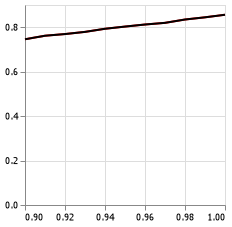

In [90]:
@vlplot(x=X)+
@vlplot(mark={:line, color=:red, strokeDash=8.8}, x=X, y=y1)+
@vlplot(mark={:line, color=:black, strokeDash=4.4}, x=X, y=y2)

In [98]:
typeof(s_propose(t, hkt, lkt2, lmt))==Float64


false

In [83]:
typeof(s_propose(t, hkt, lkt2, lmt)[1])

Float64

In [97]:
typeof(s_respond(t, hkt, lkt2, lmt))==Float64

true

In [94]:
s_respond(t, hkt, lkt2, lmt)=="Float64"

false

In [100]:
function graf1(t, lkt1, lkt2, lmt1, lmt2, f)
    
    #let's cut the X axis to show only values where hkt >=  max(lkt1, lkt2)
    cut = max(lkt1,lkt2)
    X = hvals[cut:grid]
    
    #arrays to store the outputs
    y1 = zeros(length(hvals[cut:end]))
    y2 = similar(y1)
    
    
    #by default, yi will get lkti and lmti
    
    #condition to avoid getting the wrong value when it is a tuple (ie, k_propose)
    
    if(f(t, 1, lkt1, lmt1)==Float64)
        
        for (i, hkt) in enumerate(cut:grid)
            y1[i] = f(t, hkt, lkt1, lmt1)
        end

         for (i, hkt) in enumerate(cut:grid)
            y2[i] = f(t, hkt, lkt2, lmt2)
        end
    else
         for (i, hkt) in enumerate(cut:grid)
            y1[i] = f(t, hkt, lkt1, lmt1)[1]
        end

         for (i, hkt) in enumerate(cut:grid)
            y2[i] = f(t, hkt, lkt2, lmt2)[1]
        end
    end

    
    #plotting
    
    
    @vlplot(x=X)+
    @vlplot(mark={:line, color=:blue}, x=X, y=y1)+
    @vlplot(mark={:line, color=:orange}, x=X, y=y2)
    
    

end




graf1 (generic function with 1 method)

Gráficos da função s_propose

WARN Layer's shared x channel is overriden.
WARN Layer's shared x channel is overriden.
WARN Layer's shared x channel is overriden.
WARN Layer's shared x channel is overriden.


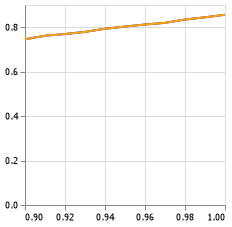

In [107]:
#variando lkt
graf1(1, 50, 90, 50, 50, s_propose)

WARN Layer's shared x channel is overriden.
WARN Layer's shared x channel is overriden.
WARN Layer's shared x channel is overriden.
WARN Layer's shared x channel is overriden.


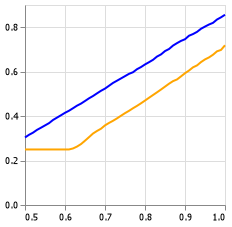

In [108]:
#variando lmt
graf1(1, 50, 50, 50, 90, s_propose)

Gráficos da função s_respond

WARN Layer's shared x channel is overriden.
WARN Layer's shared x channel is overriden.
WARN Layer's shared x channel is overriden.
WARN Layer's shared x channel is overriden.


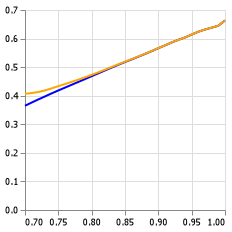

In [110]:
#variando lkt
graf1(1, 30, 70, 80, 80, s_respond)

WARN Layer's shared x channel is overriden.
WARN Layer's shared x channel is overriden.
WARN Layer's shared x channel is overriden.
WARN Layer's shared x channel is overriden.


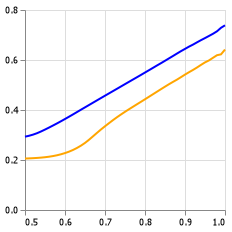

In [111]:
#variando lmt
graf1(1, 50, 50, 50, 90, s_respond)

Gráficos da função valor de continuação

In [112]:
t, lkt1, lkt2, lmt1, lmt2 = 1, 1, 1, 1, 1

y1 = s_W[t, lkt1:end, lkt1, lmt1]
y2 = j_W[t, lkt2:end, lkt2, lmt2]



100-element Array{Float64,1}:
 0.00824427461879578
 0.008794015422302147
 0.009288152893732516
 0.0099588266895469
 0.010682129982710925
 0.01147420451509994
 0.012224833074018941
 0.01316353125766958
 0.014200502221652495
 0.01522042127910797
 0.016469859395667783
 0.01785400411664427
 0.019284445057116507
 ⋮
 0.6718750983830537
 0.6798807589599589
 0.6881911946695678
 0.6985676622311876
 0.7075763298770908
 0.7162519923520161
 0.7245397239948463
 0.732813869350363
 0.7421371413865268
 0.7525305190023719
 0.7611596680587893
 0.7707418754370718

WARN Layer's shared x channel is overriden.
WARN Layer's shared x channel is overriden.
WARN Layer's shared x channel is overriden.
WARN Layer's shared x channel is overriden.


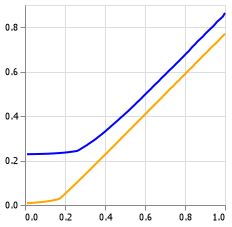

In [116]:
@vlplot(x=hvals)+
@vlplot(mark={:line, color=:blue}, x=hvals,y=y1)+
@vlplot(mark={:line, color=:orange}, x=hvals,y=y2)

WARN Layer's shared x channel is overriden.
WARN Layer's shared x channel is overriden.
WARN Layer's shared x channel is overriden.
WARN Layer's shared x channel is overriden.


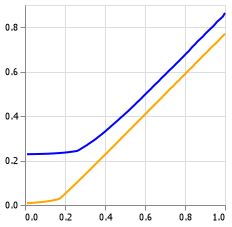

In [118]:
function graf_func_value(t, lkt, lmt)
    
    #now the cut is just lkt
    X=hvals[lkt:end]
    
    y1=s_W[t, lkt:end, lkt, lmt]
    y2=j_W[t, lkt:end, lkt, lmt]
    
    
    @vlplot(x=X)+
    @vlplot(mark={:line, color=:blue}, x=X, y=y1)+
    @vlplot(mark={:line, color=:orange}, x=X, y=y2)
    
    
end


graf_func_value(1,1,1)
    